In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1
p["errorbar.capsize"] = 2


In [3]:
headers = []
datas = []
for run in sorted(glob('../data/position_radial/*')):
    header = np.loadtxt(run, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    headers.append(header)

    data = np.loadtxt(run, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append((V_in_combined, I_out_combined, I_out_std_combined))

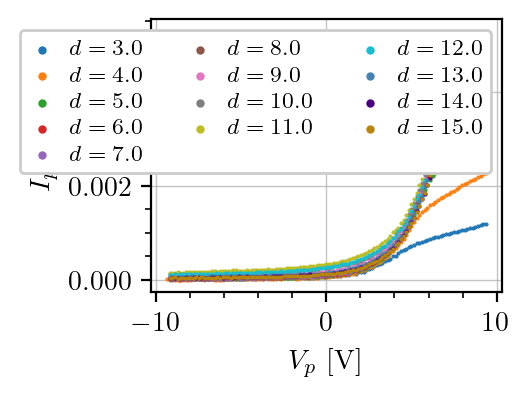

In [4]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for header, data in zip(headers, datas):
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out, I_out_std = data

    plt.scatter(V_in, I_out, label=f"$d = {d}$")
    idx = I_out < 0
    # plt.scatter(V_in[idx], I_out[idx])
    plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

In [5]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

Fit number 0
4.49+/-0.13 0.000749+/-0.000015
T_e_run = (1.87±0.06)×10⁴, T_run = (1.62±0.06)×10⁰, n_e_run = (7.0±0.2)×10¹⁵
Fit number 1
5.46+/-0.10 0.00155+/-0.00004
T_e_run = (1.93±0.05)×10⁴, T_run = (1.66±0.05)×10⁰, n_e_run = (1.42±0.04)×10¹⁶
Fit number 2
6.10+/-0.15 0.00222+/-0.00010
T_e_run = (2.02±0.06)×10⁴, T_run = (1.74±0.05)×10⁰, n_e_run = (1.99±0.09)×10¹⁶
Fit number 3
6.48+/-0.23 0.00278+/-0.00013
T_e_run = (2.06±0.07)×10⁴, T_run = (1.78±0.06)×10⁰, n_e_run = (2.5±0.1)×10¹⁶
Fit number 4
6.54+/-0.12 0.00318+/-0.00011
T_e_run = (2.04±0.05)×10⁴, T_run = (1.76±0.05)×10⁰, n_e_run = (2.8±0.1)×10¹⁶
Fit number 5
6.70+/-0.10 0.00346+/-0.00016
T_e_run = (2.13±0.05)×10⁴, T_run = (1.84±0.04)×10⁰, n_e_run = (3.0±0.1)×10¹⁶
Fit number 6
6.82+/-0.14 0.00372+/-0.00022
T_e_run = (2.22±0.05)×10⁴, T_run = (1.91±0.05)×10⁰, n_e_run = (3.2±0.2)×10¹⁶
Fit number 7
6.98+/-0.13 0.00402+/-0.00020
T_e_run = (2.35±0.05)×10⁴, T_run = (2.03±0.05)×10⁰, n_e_run = (3.3±0.2)×10¹⁶
Fit number 8
7.11+/-0.16 0.00432+/

/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_9931/709032311.py:50: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_9931/709032311.py:67: RuntimeWarning: invalid value encountered in log
  plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")


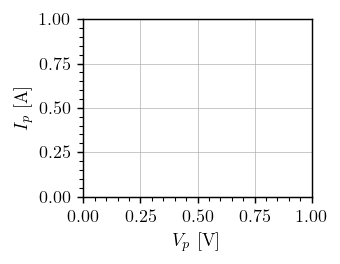

In [6]:
T_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
T = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
n_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))

B_fit_start = np.ones(len(datas))*0.5
B_fit_stop = np.ones(len(datas))*3
C_fit_start = np.ones(len(datas))*6

B_fit_start[0] = 1
B_fit_stop[0] = 4
B_fit_start[1] = 2
B_fit_stop[1] = 5
C_fit_start[1] = 7
B_fit_start[4] = 4
B_fit_stop[4] = 6
C_fit_start[4] = 7
B_fit_start[5] = 2
B_fit_stop[5] = 6
C_fit_start[5] = 7
B_fit_start[6] = 3
B_fit_stop[6] = 6
C_fit_start[6] = 7
B_fit_start[7] = 4
B_fit_stop[7] = 7
C_fit_start[7] = 7
B_fit_start[8] = 4
B_fit_stop[8] = 7
C_fit_start[8] = 7.5
B_fit_start[9] = 5
B_fit_stop[9] = 7
C_fit_start[9] = 7.5
B_fit_start[10] = 5
B_fit_stop[10] = 7
C_fit_start[10] = 8
B_fit_start[11] = 3
B_fit_stop[11] = 7
C_fit_start[11] = 8
B_fit_start[12] = 3
B_fit_stop[12] = 7
C_fit_start[12] = 8



for i, (header, data) in enumerate(zip(headers, datas)):
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out, I_out_std = data

    print(f"Fit number {i}")

    dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
    threshold = 7e-2
    idx = np.abs(np.diff(dydx, prepend=0)) < threshold
    idx = np.logical_and(idx, V_in > B_fit_start[i])
    idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i]))
    idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i]))
    # idx_B = np.logical_and(0 < V_in, V_in < 3)
    # idx_C = V_in > 6

    coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
    coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
    fitfuncB = np.poly1d(coefsB)
    coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
    coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
    fitfuncC = np.poly1d(coefsC)

    x = np.linspace(V_in[0], V_in[-1])
    plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")
    plt.plot(x, fitfuncB(x))
    plt.plot(x, fitfuncC(x))

    V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
    I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
    print(V_sp, I_sp)
    plt.axvline(V_sp.n)
    plt.axhline(umath.log(I_sp).n)

    T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
    T_e_run += ufloat(0, 0.05e4)
    T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
    # TODO: verifier unitées
    n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
    print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
    T_e[i] = T_e_run
    T[i] = T_run
    n_e[i] = n_e_run

    plt.gcf().delaxes(plt.gca())
    plt.xlabel("$V_p$ [V]")
    plt.ylabel("$I_p$ [A]")
    # plt.legend()
    # plt.show()

In [7]:
distances = list(map(lambda header: header[1], headers))

In [8]:
p = plt.rcParams
p["figure.figsize"] = (5.75*CM_PER_INCH, 4.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.9
p['figure.subplot.bottom'] = 0.24

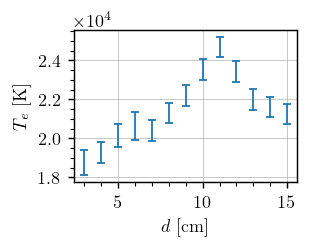

In [9]:
plt.ticklabel_format(axis='both', style='scientific', scilimits=(-3,3))

plt.errorbar(distances, nom_vals(T_e), yerr=std_devs(T_e), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$T_e$ [K]')

plt.savefig("../figures/temperatureK_position_radial.pdf")

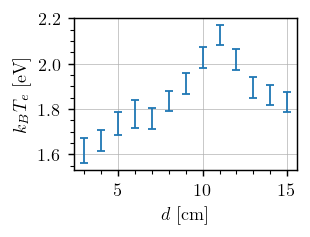

In [10]:
plt.errorbar(distances, nom_vals(T), yerr=std_devs(T), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')

plt.savefig("../figures/temperatureeV_position_radial.pdf")

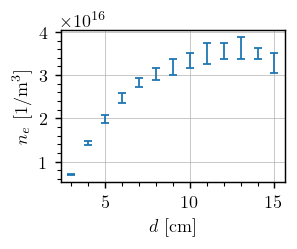

In [11]:
plt.errorbar(distances, nom_vals(n_e), yerr=std_devs(n_e), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ $[1/$m$^3]$')

plt.savefig("../figures/density_position_radial.pdf")

In [12]:
radial_distances = distances
radial_temperatures = nom_vals(T)
radial_temperatures_std = std_devs(T)
radial_densities = nom_vals(n_e)
radial_densities_std = std_devs(n_e)

## Axial

In [13]:
headers = []
datas = []
for run in sorted(glob('../data/profile/right_9.5e-3/*')):
    header = np.loadtxt(run, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    headers.append(header)

    data = np.loadtxt(run, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append((V_in_combined, I_out_combined, I_out_std_combined))

Fit number 0
2.93+/-0.07 0.00965+/-0.00033
T_e_run = (1.16±0.05)×10⁴, T_run = (1.00±0.05)×10⁰, n_e_run = (1.15±0.05)×10¹⁷
Fit number 1
2.85+/-0.04 0.00940+/-0.00025
T_e_run = (1.11±0.05)×10⁴, T_run = (9.6±0.4)×10⁻¹, n_e_run = (1.14±0.04)×10¹⁷
Fit number 2
2.73+/-0.05 0.00897+/-0.00010
T_e_run = (1.06±0.05)×10⁴, T_run = (9.1±0.5)×10⁻¹, n_e_run = (1.11±0.03)×10¹⁷
Fit number 3
2.648+/-0.026 0.00864+/-0.00007
T_e_run = (1.02±0.05)×10⁴, T_run = (8.8±0.4)×10⁻¹, n_e_run = (1.09±0.03)×10¹⁷
Fit number 4
2.63+/-0.08 0.00851+/-0.00007
T_e_run = (1.01±0.06)×10⁴, T_run = (8.7±0.5)×10⁻¹, n_e_run = (1.08±0.03)×10¹⁷
Fit number 5
2.685+/-0.035 0.00841+/-0.00006
T_e_run = (1.05±0.05)×10⁴, T_run = (9.0±0.4)×10⁻¹, n_e_run = (1.05±0.03)×10¹⁷
Fit number 6
2.65+/-0.04 0.00810+/-0.00007
T_e_run = (1.04±0.05)×10⁴, T_run = (9.0±0.4)×10⁻¹, n_e_run = (1.01±0.03)×10¹⁷
Fit number 7
2.72+/-0.07 0.00800+/-0.00013
T_e_run = (1.09±0.05)×10⁴, T_run = (9.4±0.5)×10⁻¹, n_e_run = (9.8±0.3)×10¹⁶
Fit number 8
2.56+/-0.05 0.00

/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_9931/4217529282.py:29: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_9931/4217529282.py:46: RuntimeWarning: invalid value encountered in log
  plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")


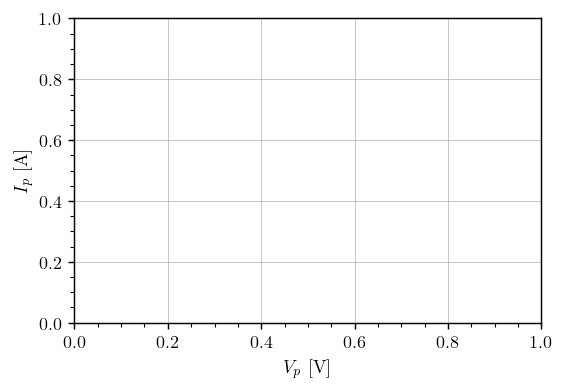

In [14]:
T_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
T = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
n_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))

B_fit_start = np.ones(len(datas))*0
B_fit_stop = np.ones(len(datas))*2
C_fit_start = np.ones(len(datas))*6

B_fit_stop[4] = 1.5
B_fit_start[15] = 0
B_fit_stop[15] = 1
# # B_fit_start[0:2] = 1
# B_fit_stop[0:1] = 4
# C_fit_start[4:] = 7.5
# B_fit_start[6:12] = 2.5
# B_fit_stop[6:12] = 6.5
# B_fit_start[9] = 4
# B_fit_start[8] = 4
# B_fit_start[12] = 3

p=plt.rcParams
p["figure.figsize"] = (12*CM_PER_INCH, 9*CM_PER_INCH)
for i, (header, data) in enumerate(zip(headers, datas)):
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out, I_out_std = data

    print(f"Fit number {i}")

    dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
    threshold = 7e-2
    idx = np.abs(np.diff(dydx, prepend=0)) < threshold
    idx = np.logical_and(idx, V_in > B_fit_start[i])
    idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i]))
    idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i]))
    # idx_B = np.logical_and(0 < V_in, V_in < 3)
    # idx_C = V_in > 6

    coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
    coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
    fitfuncB = np.poly1d(coefsB)
    coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
    coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
    fitfuncC = np.poly1d(coefsC)

    x = np.linspace(V_in[0], V_in[-1])
    plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")
    plt.plot(x, fitfuncB(x))
    plt.plot(x, fitfuncC(x))

    V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
    I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
    print(V_sp, I_sp)
    # plt.axvline(V_sp.n)
    # plt.axhline(umath.log(I_sp).n)

    T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
    if (i==15):
        T_e_run += ufloat(0, 0.05e4)
    T_e_run += ufloat(0, 0.05e4)
    T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
    # TODO: verifier unitées
    n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
    print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
    T_e[i] = T_e_run
    T[i] = T_run
    n_e[i] = n_e_run

    plt.gcf().delaxes(plt.gca())
    plt.xlabel("$V_p$ [V]")
    plt.ylabel("$I_p$ [A]")
    # plt.legend()
    # plt.show()


In [15]:
distances = list(map(lambda header: header[1], headers))

Text(0, 0.5, '$k_B T_e$ [eV]')

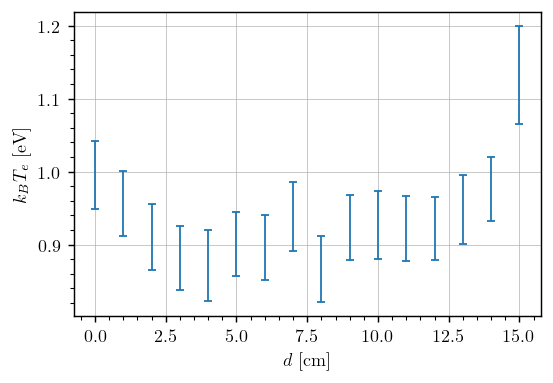

In [16]:
plt.errorbar(distances, nom_vals(T), yerr=std_devs(T), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')

# plt.savefig("../figures/temperatureeV_position_radial.pdf")

Text(0, 0.5, '$n_e$ $[1/$m$^3]$')

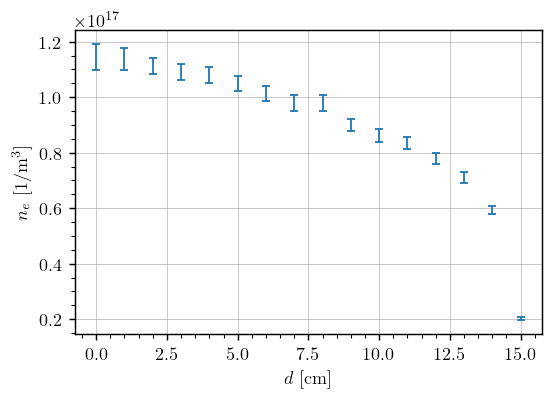

In [17]:
plt.errorbar(distances, nom_vals(n_e), yerr=std_devs(n_e), ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ $[1/$m$^3]$')

# plt.savefig("../figures/density_position_radial.pdf")

In [18]:
axial_distances = distances
axial_temperatures = nom_vals(T)
axial_temperatures_std = std_devs(T)
axial_densities = nom_vals(n_e)
axial_densities_std = std_devs(n_e)

## Combined

In [19]:
p = plt.rcParams
p["figure.figsize"] = (5.75*CM_PER_INCH, 6*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.15
p['figure.subplot.right']  = 0.9
p['figure.subplot.top']    = 0.91
p['figure.subplot.bottom'] = 0.12

p['axes.labelpad'] = -4

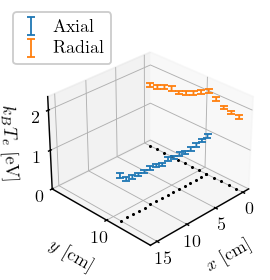

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=45, roll=0)

ax.errorbar(x=axial_distances, y=np.ones(len(axial_distances))*11, z=axial_temperatures,
            zerr=axial_temperatures_std, ls='',
            label='Axial')
ax.errorbar(x=np.zeros(len(radial_distances)), y=radial_distances, z=radial_temperatures,
            zerr=radial_temperatures_std, ls='',
            label='Radial')
# ax.scatter(xs=axial_distances, zs=np.zeros(len(axial_distances)), ys=axial_temperatures, zdir = 'y')
ax.scatter(xs=axial_distances, ys=np.ones(len(axial_distances))*11, zs=np.zeros(len(axial_distances)), zdir='z',
           c='k', s=2, depthshade=False)
ax.scatter(xs=np.zeros(len(radial_distances)), ys=radial_distances, zs=np.zeros(len(radial_distances)), zdir='z',
           c='k', s=2, depthshade=False)

ax.set_xlabel(r'$x$ [cm]', labelpad=-4)
ax.set_ylabel(r'$y$ [cm]', labelpad=-4)
ax.set_zlabel(r'$k_B T_e$ [eV]', labelpad=-8)

ax.set_zlim(bottom=0)
# ax.set_xlim(left=0)
ax.tick_params(axis='both', which='major', pad=-4)
ax.minorticks_off()
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.15))
plt.savefig("../figures/temperatureEV_profile.pdf")
plt.show()

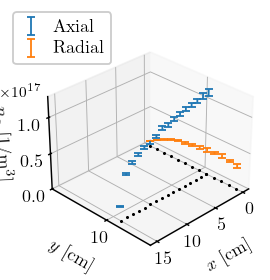

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=45, roll=0)

ax.errorbar(x=axial_distances, y=np.ones(len(axial_distances))*11, z=axial_densities,
            zerr=axial_densities_std, ls='',
            label='Axial')
ax.errorbar(x=np.zeros(len(radial_distances)), y=radial_distances, z=radial_densities,
            zerr=radial_densities_std, ls='',
            label='Radial')
# ax.scatter(xs=axial_distances, zs=np.zeros(len(axial_distances)), ys=axial_densities, zdir = 'y')
ax.scatter(xs=axial_distances, ys=np.ones(len(axial_distances))*11, zs=np.zeros(len(axial_distances)), zdir='z',
           c='k', s=2, depthshade=False)
ax.scatter(xs=np.zeros(len(radial_distances)), ys=radial_distances, zs=np.zeros(len(radial_distances)), zdir='z',
           c='k', s=2, depthshade=False)

ax.set_xlabel(r'$x$ [cm]')
ax.set_ylabel(r'$y$ [cm]')
ax.set_zlabel(r'$n_e$ [1/m$^3$]', labelpad=-6)
ax.text3D(14,-4, 1e17, r"$\times 10^{17}$",
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8)
            # transform = ax.transAxes)
plt.setp(ax.get_zaxis().get_offset_text(), visible=False)
ax.set_zlim(bottom=0)

ax.tick_params(axis='both', which='major', pad=-4)
ax.tick_params(axis='z', which='major', pad=-2)
ax.minorticks_off()
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))


plt.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.15))
plt.savefig("../figures/density_profile.pdf")

plt.show()